In [1]:
import numpy as np
import ssm
import matplotlib.pyplot as plt

/opt/miniconda3/envs/al/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Fixing random seed
seed = 1
np.random.seed(seed)

In [3]:
# Set the parameters of the GLM-HMM
num_states = 3   # number of discrete states
obs_dim = 1           # number of observed dimensions
num_categories = 2    # number of categories for output
input_dim = 2         # input dimensions

In [4]:
# Make a GLM-HMM which will be our data generator
true_iohmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard")
gen_weights = np.array([[[6, 1]], [[2, -3]], [[2, 3]]])
gen_log_trans_mat = np.log(np.array([[[0.98, 0.01, 0.01], [0.05, 0.92, 0.03], [0.02, 0.03, 0.94]]]))
true_iohmm.observations.params = gen_weights
true_iohmm.transitions.params = gen_log_trans_mat
gen_trans_mat = np.exp(gen_log_trans_mat)[0]

In [5]:
num_sess = 1 # number of example sessions
num_trials_per_sess = 100 # number of trials in a session
initial_inputs = np.ones((num_sess, num_trials_per_sess, input_dim)) # initialize inpts array
stim_vals = np.arange(-5,5,step=0.01).tolist() # Stimuli values 
initial_inputs[:,:,0] = np.random.choice(stim_vals, (num_sess, num_trials_per_sess)) # generate random sequence of potential inputs
stimuli_list = np.ones((len(stim_vals), input_dim))
stimuli_list[:,0] = stim_vals # list of all potential inputs

In [6]:
# # add selected inputs to this
# seed = 1
# chain_length = 400
# selected_inputs = np.load("Results_IOHMM/infomax_gibbs_selectedinputs_atseed"+str(seed)+"_gibbs_"+str(chain_length)+".npy")
# # find when the first time 4.99 is detected in selected inputs axis 1
# print(np.argmax(selected_inputs[:,0]))
# more_inputs = selected_inputs[0:np.argmax(selected_inputs[:,0]),:][None, :, :]
# # add ths to initial inputs
# initial_inputs = np.concatenate((initial_inputs, more_inputs), axis=1)
# print(initial_inputs.shape)

In [7]:
initial_inputs = list(initial_inputs)
# Generate a sequence of latents and choices for each 
true_latents, true_choices = [], []
for sess in range(num_sess):
    # true_z, true_y = true_iohmm.sample(num_trials_per_sess+np.argmax(selected_inputs[:,0]), input=initial_inputs[sess])
    true_z, true_y = true_iohmm.sample(num_trials_per_sess, input=initial_inputs[sess])
    true_latents.append(true_z)
    true_choices.append(true_y)

In [8]:
#Create a new test iohmm
test_iohmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                       observation_kwargs=dict(C=num_categories), transitions="standard")
# Reshaping weights to compute error later
true_weights = np.reshape(gen_weights, (num_states, input_dim))

In [9]:
obsparams_sampled, Ps_sampled, pi0_sampled, fit_ll, pzts_persample  = test_iohmm.fit(true_choices, inputs=initial_inputs, method='gibbs', burnin=200)

LP: -42.7: 100%|██████████| 700/700 [00:09<00:00, 73.22it/s]


In [35]:
# compute time for MI as a function of # of stimuli
from ssm.input_selection import input_selection
from ssm.util import one_hot, find_permutation, permute_params
import time

list_sizes = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
time_needed = []
num_repeats = 50

for list_size in list_sizes:
    time_this_size = 0
    for n in range(num_repeats):
        time0 = time.time()
        all_stimuli = stimuli_list[:list_size]
        x_new, mi = input_selection(seed, test_iohmm, all_stimuli, [pi0_sampled, Ps_sampled, obsparams_sampled], pzts_persample)
        time_this_size = time.time()-time0
    time_needed.append(time_this_size/num_repeats)

time_for_gibbs = 6.5


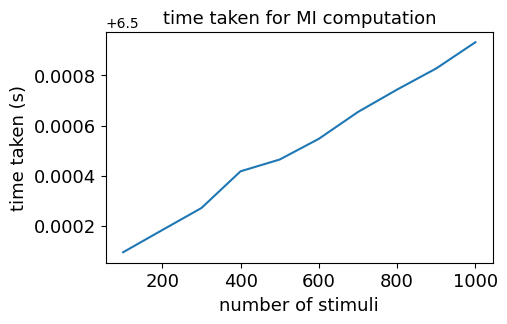

In [37]:
time_needed = np.array(time_needed) + time_for_gibbs

fig = plt.figure(figsize=(5,3))
plt.plot(list_sizes, time_needed)
plt.ylabel('time taken (s)', fontsize=13)
plt.xlabel('number of stimuli', fontsize=13)
plt.title('time taken for MI computation', fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# save figure
fig.savefig('Figs_IOHMM/MI_time.png', dpi=300, bbox_inches='tight')

Number of cores being used: 8
Computing parameters of IO-HMM using 101 samples
selected input: [-0.07  1.  ]


LP: -46.6: 100%|██████████| 500/500 [00:06<00:00, 79.66it/s]


Time taken: 6.703425884246826
Computing parameters of IO-HMM using 102 samples
selected input: [-0.49  1.  ]


LP: -42.2:  61%|██████    | 303/500 [00:03<00:02, 77.00it/s]


KeyboardInterrupt: 

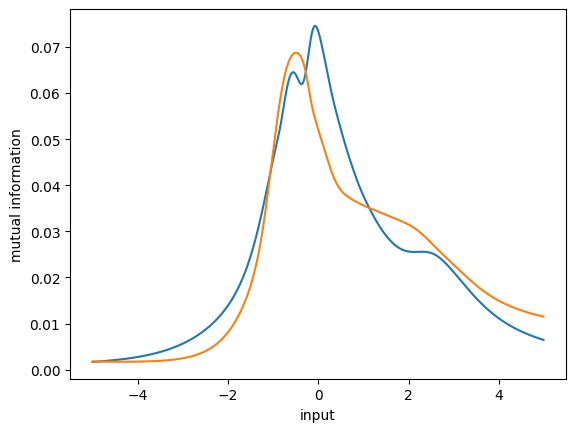

In [34]:
from ssm.input_selection import input_selection
from ssm.util import one_hot, find_permutation, permute_params
import time

# To store selected inputs at each step
selected_inputs = []
input_list = stimuli_list
inputs = initial_inputs
observations = true_choices
zs = true_latents
M = 2
K = 3

# print number of cores being used
import multiprocessing
print("Number of cores being used: "+str(multiprocessing.cpu_count()))

for t in range(100):
    print("Computing parameters of IO-HMM using "+str(t+1+num_trials_per_sess)+" samples")
    time0 = time.time()
    # Select next input from a list of possible input input
    x_new, mi = input_selection(seed, test_iohmm, input_list, [pi0_sampled, Ps_sampled, obsparams_sampled], pzts_persample)
    print("selected input: "+str(x_new))
    plt.plot(input_list[:,0], mi)
    plt.xlabel("input")
    plt.ylabel("mutual information")
    # Obtain output from the true model
    z_new, observation_new = true_iohmm.sample(T=1, input = np.reshape(np.array(x_new), (1,M)), prefix=(zs[0], observations[0]))
    # Append this to the list of inputs and outputs
    observations[0] = np.concatenate((observations[0], observation_new), axis=0)
    inputs[0] = np.concatenate((inputs[0],np.reshape(np.array(x_new), (1,M))),  axis=0).copy()
    zs[0] = np.concatenate((zs[0], z_new))

    obsparams_sampled, Ps_sampled, pi0_sampled, fit_ll, pzts_persample  = test_iohmm.fit(observations, inputs=inputs, method='gibbs', num_iters = 400, burnin=100)

    # Permute
    perm = find_permutation(zs[0], test_iohmm.most_likely_states(observations[0], input=inputs[0]), K, K)
    test_iohmm.permute(perm)

    obsparams_sampled = obsparams_sampled[:,perm,:].copy()       
    Ps_sampled = Ps_sampled[:,perm,:].copy()
    Ps_sampled = Ps_sampled[:,:,perm].copy()
    pi0_sampled = pi0_sampled[:,perm].copy()
    pzts_persample = pzts_persample[:,perm].copy() 
    
    # To store selected inputs at each step
    selected_inputs.append(x_new)
    print("Time taken: "+str(time.time()-time0))
